##Lab 1

In this lab, we will try to identify heart beats from a 3-lead ECG signal, calculate the heart rate (HR) and plot the heart rate variability (HRV). We will utilize the Pan-Tompkins algorithm (more information [here](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm)) to process and analyze our ECG signal. This algorithm amplifies the R peaks to separate it from the noise and the rest of the signal, making the heart beat identification a lot more straightforward.

Please follow the code to finish the lab, and submit a report based on the provided template on Canvas.

#
If you haven't coded in Python before, here are some Python tutorials for beginners to help you catup up to speed:

https://www.w3schools.com/python/default.asp

https://wiki.python.org/moin/BeginnersGuide/Programmers



In [1]:
# Scientific packages
import numpy as np
from numpy import linspace, diff, zeros_like, arange, array
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

Step 1: Load the signal

In [2]:
# Sampling frequency of acquired data
fs = 500 #500Hz

# Example data is provided on Canvas
# TODO: read from your raw data file and save as a numpy array
signal = np.loadtxt('ECG_data.csv')

# TODO: Generate the time axis of the signal given its sampling frequency
# hint: length of time and signal should be the same, each 2 timestamps differ by 1/fs
# make sure to convert to numpy array
length = len(signal)
period = 1/fs
total_time = length * period
time = np.arange(0, total_time, period)

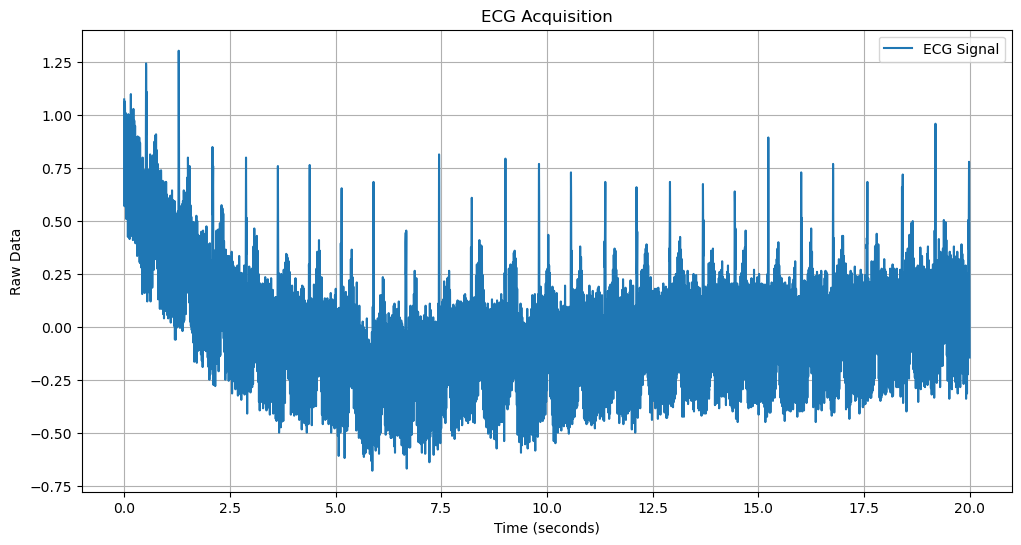

In [3]:
# Plotting the ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal, label='ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Step 2: Now we start the P-T algorithm.

We will first apply a band-pass filter to the raw signal.

In [4]:
# Helper function: band-pass filter for ECG
def ecg_band_pass_filter(data, sample_rate):
    """
    Bandpass filter with a bandpass setting of 5 to 15 Hz
    ----------
    Parameters
    ----------
    data : list
        List with the ECG signal samples.
    sample_rate : int
        Sampling rate at which the acquisition took place.
    -------
    Returns
    -------
    out : list
        Filtered signal.
    """
    nyquist_sample_rate = sample_rate / 2.
    normalized_cut_offs = [5/nyquist_sample_rate, 15/nyquist_sample_rate]
    b_coeff, a_coeff = butter(2, normalized_cut_offs, btype='bandpass')[:2]
    return filtfilt(b_coeff, a_coeff, data, padlen=150)

In [5]:
# TODO: Apply band-pass filter to the raw signal
# hint: use the helper function provided in the previous code block
filtered_signal = ecg_band_pass_filter(signal, fs)

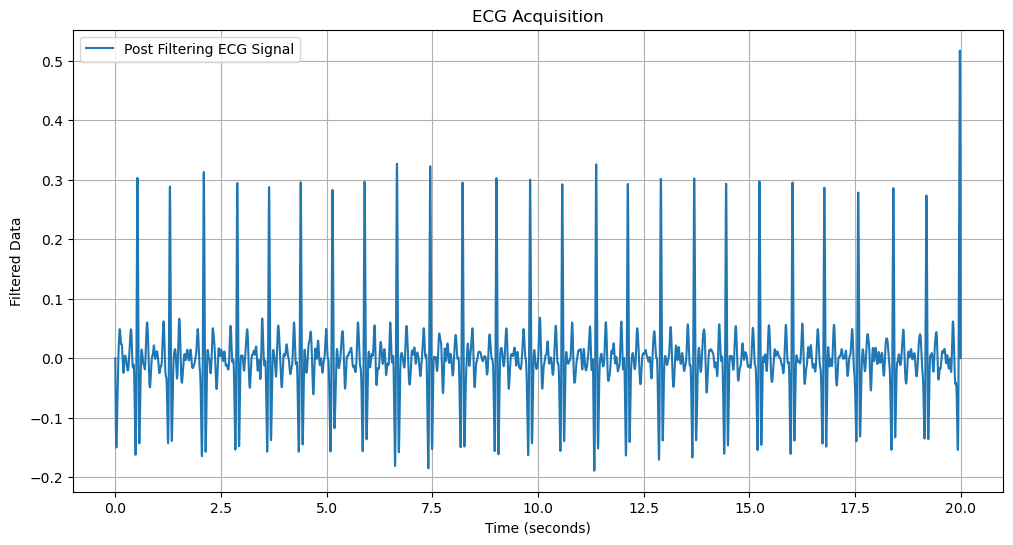

In [6]:
# Plotting the filtered ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time, filtered_signal, label='Post Filtering ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Filtered Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Step 3: apply a deriative filter

In [7]:
# TODO: Differentiate the filtered signal
# hint: use numpy.diff
differentiated_signal = np.diff(filtered_signal)

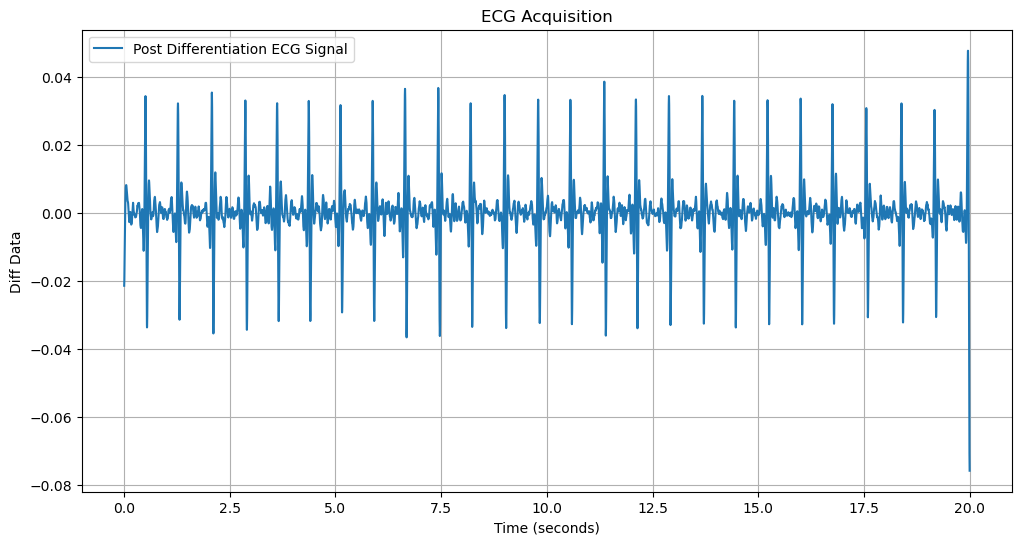

In [8]:
# Plotting the differentiated ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time[1:], differentiated_signal, label='Post Differentiation ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Diff Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Step 4: Applying squaring and integration

In [18]:
# TODO: Square the differentiated signal
# hint: In this case, squaring is the same as an element-wise multiplication with itself
squared_signal = np.square(differentiated_signal)

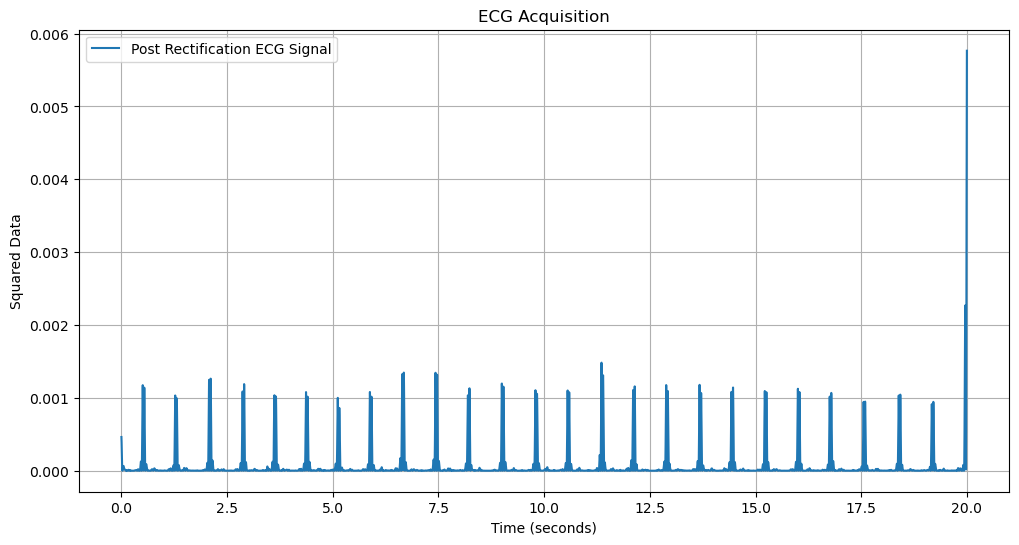

In [20]:
# Plotting the squared ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time[1:], squared_signal, label='Post Rectification ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Squared Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Step 5: Apply a moving average window

In [22]:
# Definition of the samples number inside the moving average window
nbr_sampls_int_wind = int(0.080 * fs) # window size of 0.08 second

# TODO: Initialize a variable that will contain the integrated signal samples
# Hint: initialize all with zeros, use zeros_like()
integrated_signal = zeros_like(squared_signal)

# TODO: Determine a cumulative version of "squared_signal"
# Hint: use .cumsum()
cumulative_sum = squared_signal.cumsum()

# Estimate the area/integral below the curve that defines the "squared_signal"
integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] -
                                           cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / arange(1, nbr_sampls_int_wind + 1)

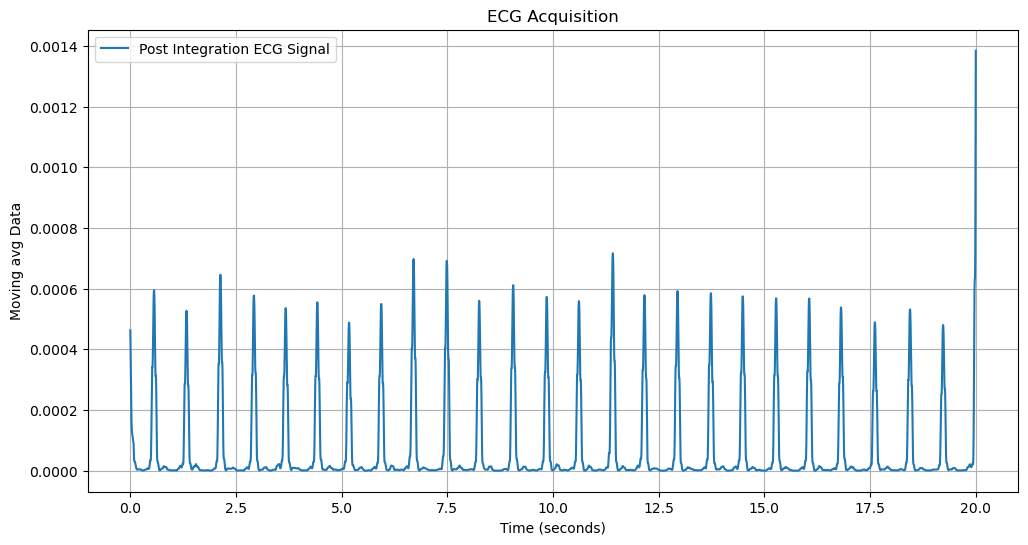

In [25]:
# Plotting the ECG signal after moving average
plt.figure(figsize=(12, 6))
plt.plot(time[1:], integrated_signal, label='Post Integration ECG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Moving avg Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Now that we have a processed singal that amplifies the QRS complex, we can detect and analyze the R peaks to get physical measurements like heart rate and heart rate variability. Heart rate is the frequency of beating of the heart, whereas heart rate variability is the time between each two beats of the heart.

But to do all of that, we will first need to identify the timestamp of all heart beat signals. we will utilize a simplified version since our data is relatively clean and straightforward. For the full Pan-Tompkins method on peak detection, please refer to [the original paper](https://doi.org/10.1109/TBME.1985.325532).

Step 6: detect the location of amplified R peaks

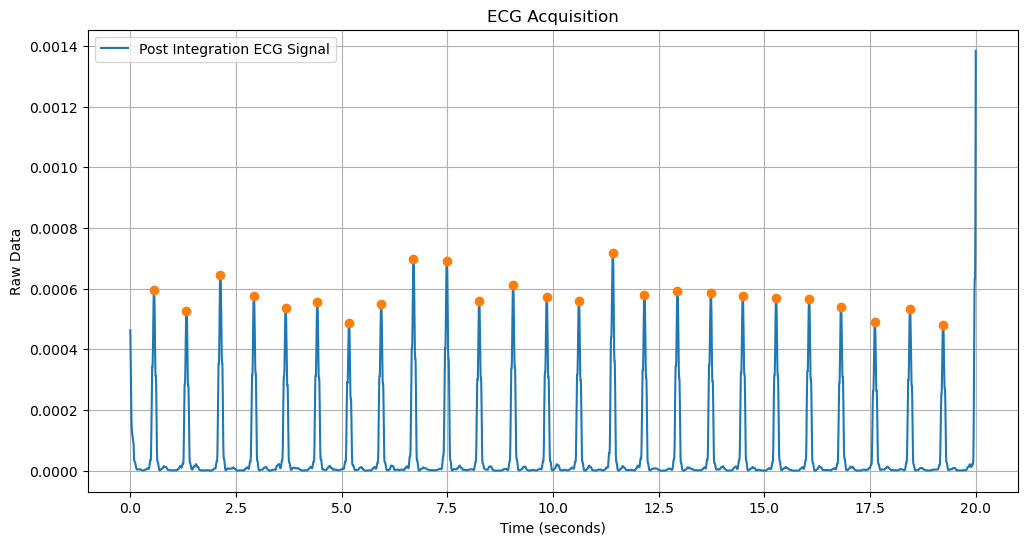

In [30]:
# TODO: detect the location of all amplified R peaks
# Hint: use find_peaks()
# You would need to tune the parameters to detect true R peaks only
# Recommended parameters to tune are distance & height
# One useful knowledge: after each heartbeat, there is an absolute refractory period of around 200ms where another heartbeat cannot be triggered no matter what
peak_ind = find_peaks(integrated_signal, height=0.0003,distance=250)[0]

# TODO: timestamp of all peaks
peak_time = peak_ind / fs

# TODO: magnitude of all peaks
peaks = []
for index in peak_ind:
    peaks.append(integrated_signal[index])

# You can use this plot to validate your parameter tuning results
# Plotting the integrated ECG signal with peaks
plt.figure(figsize=(12, 6))
plt.plot(time[1:], integrated_signal, label='Post Integration ECG Signal')
plt.plot(peak_time,peaks,'o')
plt.xlabel('Time (seconds)')
plt.ylabel('Raw Data')
plt.title('ECG Acquisition')
plt.legend()
plt.grid(True)
plt.show()

Now with each heart beat detected, you should be able to calculate heart rate in beats per minute (BPM)

In [31]:
# Calculate the heart rate per minute
diff = np.diff(peak_time)
avg_sec_per_beat = diff.mean()
hr = 60/avg_sec_per_beat
print(f"Average Heart Rate: {hr}")

Average Heart Rate: 77.16214767977709


Next, let's find the heart-rate variability (HRV) and plot as a tachogram

Plotting HRV as tachogram would show us the time variation between heartbeats. A higher HRV typically corresponds to lower stress, since the heart rate is steadier

In [39]:
# TODO: Find tachogram by taking the diff between peak_time
# Hint: use np.diff()
tachogram = np.diff(peak_time)

# The tachogram time can be obtained by shifting each point of heartbeat duration to the center of the two adjacent peaks.
# Hint: use the variable peak_time.
tachogram_time = peak_time[0:-1]

In [40]:
np.sqrt(np.mean(np.square(tachogram)))*1000

777.8833460101843

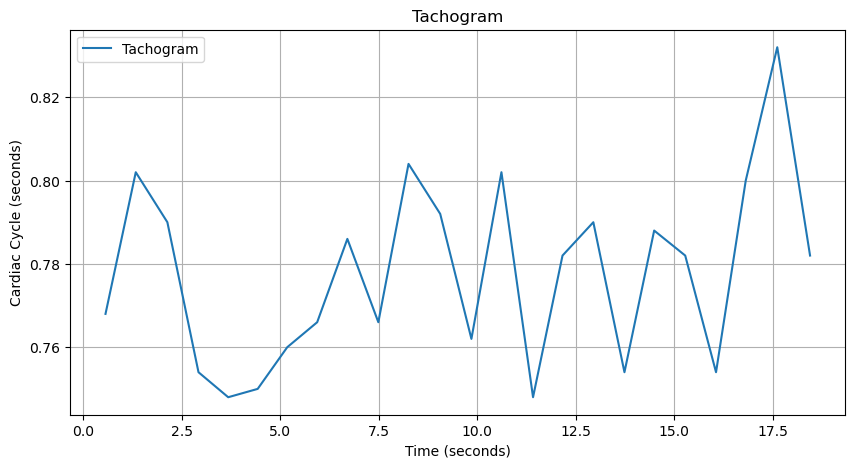

In [38]:
# Plotting the tachogram
plt.figure(figsize=(10, 5))
plt.plot(tachogram_time, tachogram, label='Tachogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Cardiac Cycle (seconds)')
plt.title('Tachogram')
plt.legend()
plt.grid(True)
plt.show()

Now that you have all the data and the plots, please compile a report showing what you did in this lab. It should include a step-by-step description of what you did, the signal plot after each step, as well as all calculation results. Make sure each plot is adequately labeled. If parameters of any filters are tuned, briefly explain the reason for choosing the specific values